In [1]:
import os
import pandas as pd
import numpy as np
import re
import glob
import json
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [2]:
#prepare data from MMJ-Processed_data-2022_05_27-13_58-6858bbe.csv


def create_subs_df(group,ses,task,contrast):
    effect_size_maps = glob.glob(f'../../../derivatives/nilearn/first_level/sub-{group}*/ses-{ses}/task-{task}/sub-{group}*_ses-{ses}_task-{task}_rec-unco_run-1_contrast-{contrast}_effect_size.nii.gz')
    non_img_data = pd.read_csv(f"../../../sourcedata/non_imaging_data/MMJ-Processed_data-2022_05_27-13_58-6858bbe.csv",low_memory=False)

    #need to find subjects that have data for this contrast
    subs = [path.split('/sub-')[1].split('/')[0] for path in effect_size_maps if path]
    subs = ['_'.join([s for s in re.split(r'(MM|HC)', sub) if s]) for sub in subs]
    df_subs = pd.DataFrame(subs,columns=['subs'])


    #add columns for male and female, that will then be combined to create the group average 
    grouped_sex = non_img_data.groupby("IDS.CHR.Subject")["SBJ.CHR.Sex"].agg("first")
    dict_sex = grouped_sex.to_dict()
    df_subs = pd.concat([df_subs,pd.get_dummies(df_subs['subs'].map(dict_sex))],axis=1,copy=False)

    #add age, mean-centered
    grouped_age = non_img_data.groupby("IDS.CHR.Subject")["SBJ.INT.Age"].agg("first")
    dict_age = grouped_age.to_dict()
    df_subs['age'] = df_subs['subs'].map(dict_age)
    df_subs['age'] = df_subs['age'] - df_subs['age'].mean()

    #add CUDIT summed score, mean-centered
    if group == 'HC': 
        grouped_HC_baseline_cudit = non_img_data[non_img_data['SSS.CHR.Time_point'] == 'Screening'].groupby('IDS.CHR.Subject')['INV.INT.CUDIT.Summed_score'].agg("first")
        dict_HC_baseline_cudit = grouped_HC_baseline_cudit.to_dict()
        df_subs['total_cudit'] = df_subs['subs'].map(dict_HC_baseline_cudit)
        df_subs['total_cudit'] = df_subs['total_cudit'] - df_subs['total_cudit'].mean()

    else:
        if ses == 'baseline':
            dict_MM_baseline_cudit = non_img_data[non_img_data['SSS.CHR.Time_point'] == 'Baseline'].groupby('IDS.CHR.Subject')['INV.INT.CUDIT.Summed_score'].agg("first").to_dict()
            df_subs['total_cudit'] = df_subs['subs'].map(dict_MM_baseline_cudit)
            df_subs['total_cudit'] = df_subs['total_cudit'] - df_subs['total_cudit'].mean()
            df_subs['total_cudit'].fillna(0, inplace=True)

        else:
            dict_MM_1year_cudit = non_img_data[non_img_data['SSS.CHR.Time_point'] == 'One year'].groupby('IDS.CHR.Subject')['INV.INT.CUDIT.Summed_score'].agg("first").to_dict()
            df_subs['total_cudit'] = df_subs['subs'].map(dict_MM_1year_cudit)
            df_subs['total_cudit'] = df_subs['total_cudit'] - df_subs['total_cudit'].mean()

    #add frequency of THC use per month, mean-centered
    freq_dict = {'Once or more per day':7,
     '5-6 days a week':6,
     '3-4 days a week':5,
     '1-2 days a week':4,
     'Less than once a week':3,
     'Less than once every two weeks':2,
     'Less than once a month':1,
     None:0,
     }

    if group == 'HC':
        #results from screening visit (using this for consistency since CUDIT-R was also collected at screening visit)
        dict_HC_screening_THC = non_img_data[non_img_data['SSS.CHR.Time_point'] == 'Screening'].groupby('IDS.CHR.Subject')['TLF.CHR.THC.Frequency_in_month'].agg("last").to_dict()
        dict_HC_screening_THC_num = {k:freq_dict[v] for k,v in dict_HC_screening_THC.items()}
        df_subs['THC_freq_month'] = df_subs['subs'].map(dict_HC_screening_THC_num)
        df_subs['THC_freq_month'] = df_subs['THC_freq_month'] - df_subs['THC_freq_month'].mean()

    else:
        if ses == 'baseline':     
            #results from MRI visit (using this for consistency since CUDIT-R was also collected at MRI visit)
            dict_MM_MRIvisit_THC = non_img_data[non_img_data['SSS.CHR.Time_point'] == 'Baseline'].groupby('IDS.CHR.Subject')['TLF.CHR.THC.Frequency_in_month'].agg("first").to_dict()
            dict_MM_MRIvisit_THC_num = {k:freq_dict[v] for k,v in dict_MM_MRIvisit_THC.items()}
            df_subs['THC_freq_month'] = df_subs['subs'].map(dict_MM_MRIvisit_THC_num)
            df_subs['THC_freq_month'] = df_subs['THC_freq_month'] - df_subs['THC_freq_month'].mean()

        else:
            dict_MM_MRIvisit_THC = non_img_data[non_img_data['SSS.CHR.Time_point'] == 'One year'].groupby('IDS.CHR.Subject')['TLF.CHR.THC.Frequency_in_month'].agg("first").to_dict()
            dict_MM_MRIvisit_THC_num = {k:freq_dict[v] for k,v in dict_MM_MRIvisit_THC.items()}
            df_subs['THC_freq_month'] = df_subs['subs'].map(dict_MM_MRIvisit_THC_num)
            df_subs['THC_freq_month'] = df_subs['THC_freq_month'] - df_subs['THC_freq_month'].mean()
    
    return df_subs



In [3]:
#prepare matching data from 

def create_merged_df(df_subs):
    if group == 'HC':
        nback_data = pd.read_csv(f"../../../sourcedata/non_imaging_data/nback_RT_ACC/nback_Accuracy_RTime_HC.csv",low_memory=False)
        nback_data=nback_data.rename(columns = {'subject':'subs'})
    else:
        nback_data = pd.read_csv(f"../../../sourcedata/non_imaging_data/nback_RT_ACC/nback_Accuracy_RTime.csv",low_memory=False)
        nback_data=nback_data.rename(columns = {'subject':'subs'})
        if ses == 'baseline':
            nback_data=nback_data[nback_data['timepoint']=='baseline']
        else:
            nback_data=nback_data[nback_data['timepoint']=='1year']

    nback_data.drop(columns=['timepoint'], inplace = True)

    for column in nback_data.columns[1:]:
        nback_data[column] = nback_data[column] - nback_data[column].mean()
        nback_data[column].fillna(0, inplace=True)

    merged_data = pd.merge(df_subs, nback_data, on='subs')
    
    return merged_data
    

In [4]:
#plot THC freq vs. acc and RT

def OLS_THC_nback(merged_data,regression_y):
    for column in merged_data.columns[6:]:
        #regress y onto x (without an intercept since everything is mean-centered)
        model = sm.OLS(merged_data[regression_y], merged_data[column])
        results = model.fit()
        slope = results.params[0]
        intercept = 0 #mean-centered data
        print(results.summary())

        # scatter-plot data
        ax = merged_data.plot(x=column, y=regression_y, kind='scatter')

        # generate x-values for your regression line
        x = np.array([merged_data[column].min()*2, merged_data[column].max()*2])

        # plot regression line on the same axes, set x-axis limits
        ax.plot(x, slope * x)
        ax.set_xlim([merged_data[column].min()*1.5,  merged_data[column].max()*1.5])


In [5]:
#set this as desired
group='MM'
ses='1year'
task='nback'
contrast='twoback-zeroback'

df_subs = create_subs_df(group,ses,task,contrast)
merged_data = create_merged_df(df_subs)

display(merged_data)

,subs,Female,Male,age,total_cudit,THC_freq_month,ACC_all,RT_all_cor,ACC_0b,RT_0b_cor,ACC_2b,RT_2b_cor
0,MM_028,1,0,18.155172,-2.655172,-3.448276,0.002721,-20.901035,0.084354,-23.694270,-0.078912,-6.907970
1,MM_044,1,0,20.155172,4.344828,2.551724,-0.313946,131.125420,-0.715646,67.539063,0.087755,110.416743
2,MM_053,0,1,-12.844828,-1.655172,-0.448276,0.069388,-48.884432,0.084354,-9.194270,0.054422,-88.503208
3,MM_054,1,0,-12.844828,2.344828,1.551724,0.019388,-6.505749,0.051020,-38.800018,-0.012245,34.290748
4,MM_062,1,0,3.155172,-2.655172,-1.448276,0.102721,-92.560294,0.084354,-49.094270,0.121088,-136.157970
5,MM_075,1,0,-11.844828,-2.655172,0.551724,0.086054,-6.753515,0.084354,-44.694270,0.087755,33.830536
6,MM_085,0,1,4.155172,5.344828,1.551724,-0.897279,0.000000,-0.915646,0.000000,-0.878912,0.000000
7,MM_086,1,0,-4.844828,-1.655172,0.551724,0.019388,-16.705749,0.051020,-52.765535,-0.012245,28.290748
8,MM_091,1,0,-12.844828,-1.655172,-0.448276,0.102721,-16.010294,0.084354,-11.360937,0.121088,-20.791303
9,MM_095,1,0,-19.844828,-0.655172,0.551724,0.052721,-44.774329,0.084354,7.272396,0.021088,-98.009822


                                 OLS Regression Results                                
Dep. Variable:            total_cudit   R-squared (uncentered):                   0.089
Model:                            OLS   Adj. R-squared (uncentered):              0.069
Method:                 Least Squares   F-statistic:                              4.489
Date:                Tue, 10 Jan 2023   Prob (F-statistic):                      0.0395
Time:                        11:12:21   Log-Likelihood:                         -114.70
No. Observations:                  47   AIC:                                      231.4
Df Residuals:                      46   BIC:                                      233.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

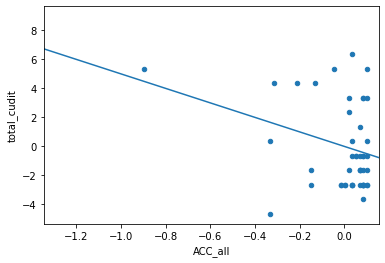

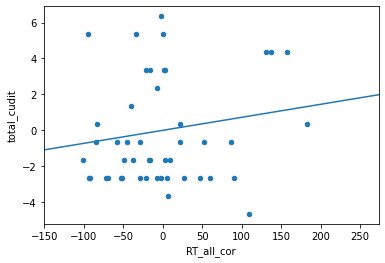

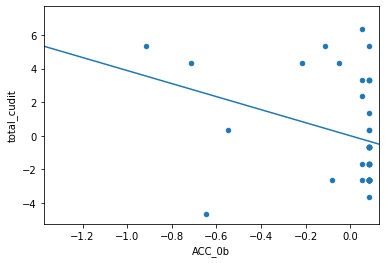

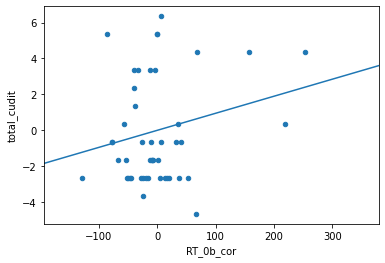

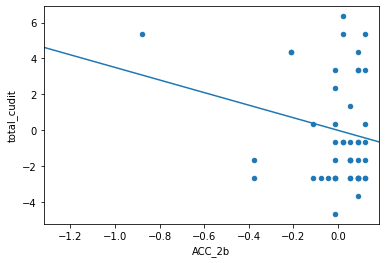

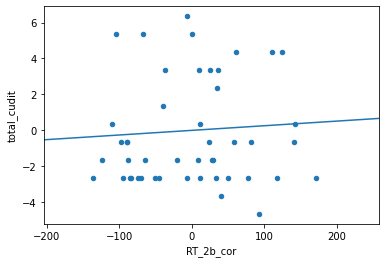

In [6]:
regression_y = 'total_cudit'

OLS_THC_nback(merged_data, regression_y)

                                 OLS Regression Results                                
Dep. Variable:         THC_freq_month   R-squared (uncentered):                   0.038
Model:                            OLS   Adj. R-squared (uncentered):              0.017
Method:                 Least Squares   F-statistic:                              1.794
Date:                Tue, 10 Jan 2023   Prob (F-statistic):                       0.187
Time:                        11:12:23   Log-Likelihood:                         -90.819
No. Observations:                  47   AIC:                                      183.6
Df Residuals:                      46   BIC:                                      185.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

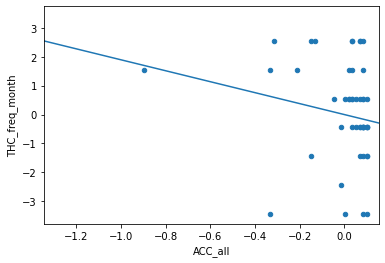

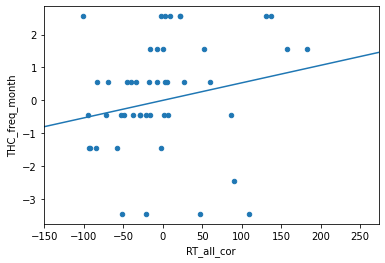

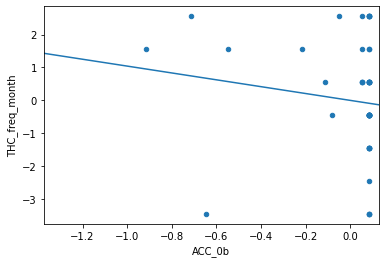

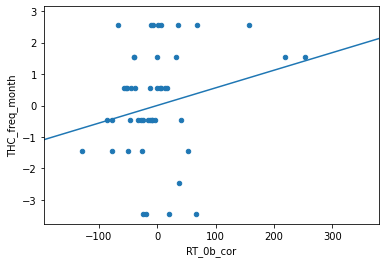

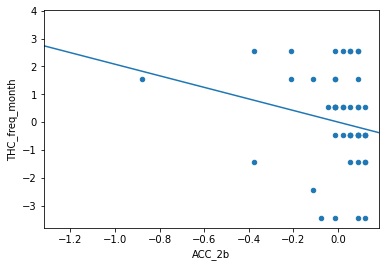

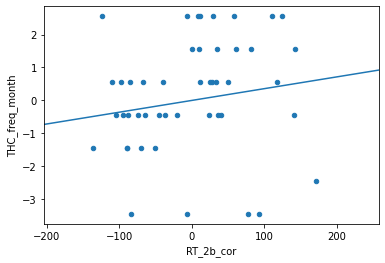

In [7]:
regression_y = 'THC_freq_month'

OLS_THC_nback(merged_data, regression_y)